## Quantum Computing Bell State

In [1]:
import time
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, execute
from qiskit.providers.jobstatus import JobStatus
from qiskit.providers.aer import noise
#from qiskit.tools.visualization import plot_histogram

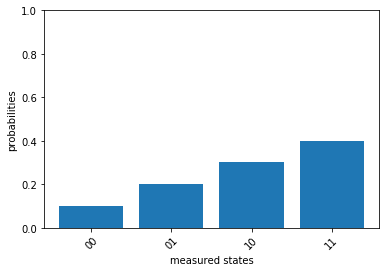

In [2]:
# given a python dict probability distribution
# generate a plot of the probability histogram

def plot_histogram(counts, title=""):
    n = len(next(iter(counts))) # get length of a ket in distribution
    N = 0 # total number of shots
    labels = list() # label each ket on x axis
    values = list() # number of shots measured for each ket
    for i in range(2**n):
        ket = format(i, "0%db" % n) # convert int to binary string
        labels.append(ket)
        if ket not in counts:
            values.append(0)
        else:
            values.append(counts[ket])
            N += counts[ket]

    # plot histogram of probabilities
    labels_num = range(len(labels))
    probs = np.array(values) / N
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.bar(labels_num, probs)
    ax.set(xticks=labels_num)
    ax.set_xticklabels(labels, rotation=45)
    ax.set(ylim=(0,1))
    ax.set(xlabel="measured states")
    ax.set(ylabel="probabilities")
    ax.set(title=title)
    return fig

plt.show(plot_histogram({"00": 100, "01": 200, "10": 300, "11": 400}))

## setup imbq and qiskit aer

In [3]:
# get backends
backends = dict()

# aer backends
for b in Aer.backends():
    backends["Aer."+str(b)] = b

# login to ibmq
token = "987d92114d0965a980e128f52d1a64870652140262a7dce07ab8ea3290d548fd" + \
        "d00abaaa1678f82c97349f1b16c3a2fb4d958405f5a3a89820012fb807b57c90"
#url = "https://quantumexperience.ng.bluemix.net/api" #v1
url = "https://auth.quantum-computing.ibm.com/api" #v2
#IBMQ.disable_account()
IBMQ.enable_account(token, url)

try:
    ibmq_backends = IBMQ.get_provider().backends()
except Exception as e: # try v1 way
    ibmq_backends = IBMQ.backends()
for b in ibmq_backends:
    backends["IBMQ."+str(b)] = b

# print backends
backend_names = list(backends.keys())
backend_names.sort()
print("backends:\n * "+("\n * ").join(backend_names))

#job = execute(qc, backend=backends["Aer.qasm_simulator"], shots=N)


# get noise profile
realboi = IBMQ.get_provider().get_backend('ibmq_16_melbourne')
properties = realboi.properties()
couple = realboi.configuration().coupling_map
noise_model = noise.device.basic_device_noise_model(properties)
basis_gates = noise_model.basis_gates
   

backends:
 * Aer.qasm_simulator
 * Aer.statevector_simulator
 * Aer.unitary_simulator
 * IBMQ.ibmq_16_melbourne
 * IBMQ.ibmq_ourense
 * IBMQ.ibmq_qasm_simulator
 * IBMQ.ibmq_vigo
 * IBMQ.ibmqx2


## define basic quantum circuit

In [4]:
def bell():
    q = QuantumRegister(2)
    c = ClassicalRegister(2)
    qc = QuantumCircuit(q, c)

    qc.h(q[0])
    qc.cx(q[0],q[1])
    qc.measure(q, c)
    return qc

# show circuit
qc = bell()
print(qc.draw())


         ┌───┐     ┌─┐   
q0_0: |0>┤ H ├──■──┤M├───
         └───┘┌─┴─┐└╥┘┌─┐
q0_1: |0>─────┤ X ├─╫─┤M├
              └───┘ ║ └╥┘
 c0_0: 0 ═══════════╩══╬═
                       ║ 
 c0_1: 0 ══════════════╩═
                         


simulating quantum computer

quantum computer simulator results:
{'11': 506, '00': 494}


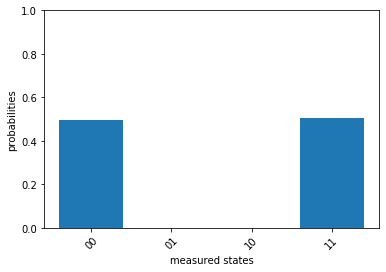

In [5]:
# run ciruit no noise
print("simulating quantum computer")
backend = backends["Aer.qasm_simulator"]
job = execute(qc, backend=backend, shots=1000)
counts = job.result().get_counts()

# show results
print(f"\nquantum computer simulator results:\n{counts}")
plt.show(plot_histogram(counts))

simulating quantum computer

quantum computer simulator results:
{'10': 86, '11': 430, '01': 89, '00': 395}


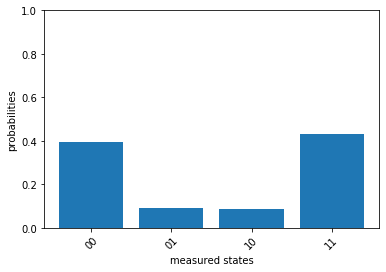

In [6]:
# run ciruit with noise
print("simulating quantum computer")
backend = backends["Aer.qasm_simulator"]
job = execute(qc, backend=backend, coupling_map=couple, noise_model=noise_model, basis_gates=basis_gates, shots=1000)
counts = job.result().get_counts()

# show results
print(f"\nquantum computer simulator results:\n{counts}")
plt.show(plot_histogram(counts))

In [7]:
# given carry, a, b, calculate (carry+a+b) and (newcarry)
def classic_adder(x="000"):
    c = int(x[0])
    a = int(x[1])
    b = int(x[2])
    out = (a + b + c) % 2
    carry = int(a + b + c >= 2)
    return out, carry

x = "000"

print(f"carryin = {x[0]}\nin1 = {x[1]}\nin2 = {x[2]}")
out, carry = classic_adder(x)
print(f"\nout = {out}\ncarry = {carry}")
    

carryin = 0
in1 = 0
in2 = 0

out = 0
carry = 0


a, b, ci -> b, co
  if (a and b): flip co
  if (a): flip b
  if (ci and b): flip co

  if (a): flip b back to orig
  if (ci): flip b to sum


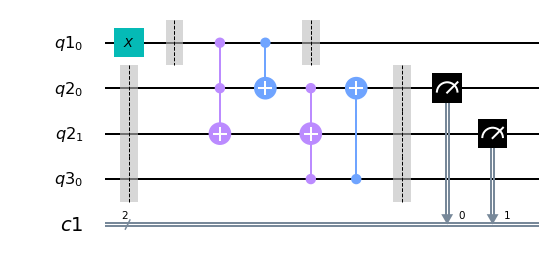

In [8]:
# given carry, a, b, calculate (carry+a+b) and (newcarry)
def adder(a="0000", b="0000"):
    a = a[::-1]
    b = b[::-1]
    n = len(a)
    qa = QuantumRegister(n)
    qb = QuantumRegister(n+1)
    qc = QuantumRegister(n)
    c = ClassicalRegister(n+1)
    circ = QuantumCircuit(qa, qb, qc, c)
    
    did_something = False
    for j in range(len(a)):
        if a[j] == "1":
            circ.x(qa[j])
            did_something = True
        if b[j] == "1":
            circ.x(qb[j])
            did_something = True
        
    if did_something:
        circ.barrier(qa)
        circ.barrier(qb)
        circ.barrier(qc)
    
#     circ.ccx(qa[0], qb[0], qc[1])
#     circ.cx(qa[0], qb[0])
#     circ.ccx(qc[0], qb[0], qc[1])
#     circ.cx(qa[0], qb[0])
#     circ.cx(qc[0], qb[0])
    for j in range(n-1):
        circ.ccx(qa[j], qb[j], qc[j+1])
        circ.cx(qa[j], qb[j])
        circ.ccx(qc[j], qb[j], qc[j+1])
    j = n-1
    circ.ccx(qa[j], qb[j], qb[j+1])
    circ.cx(qa[j], qb[j])
    circ.ccx(qc[j], qb[j], qb[j+1])
    circ.cx(qc[j], qb[j])
    
    n2 = n - 2
    for j in range(n-1):
        circ.ccx(qc[n2-j], qb[n2-j], qc[n2-j+1])
        circ.cx(qa[n2-j], qb[n2-j])
        circ.ccx(qa[n2-j], qb[n2-j], qc[n2-j+1])
        circ.cx(qa[n2-j], qb[n2-j])
        circ.cx(qc[n2-j], qb[n2-j])
        circ.cx(qa[n2-j], qb[n2-j])

    circ.barrier(qa)
    circ.barrier(qb)
    circ.barrier(qc)
    circ.measure(qb, c)
    return circ

qc = adder(a="1", b="0")

print("a, b, ci -> b, co")
print("  if (a and b): flip co")
print("  if (a): flip b")
print("  if (ci and b): flip co")
print()
print("  if (a): flip b back to orig")
print("  if (ci): flip b to sum")

fig = qc.draw(output="mpl")
fig

simulating quantum computer

quantum computer simulator results:
{'01': 1000}


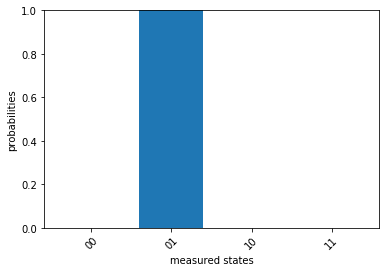

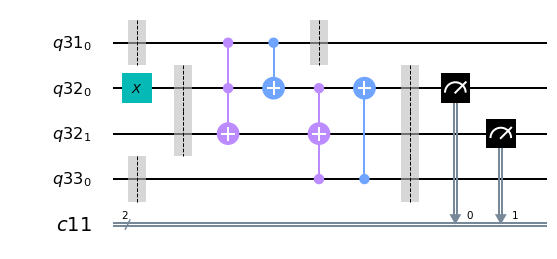

In [18]:
qc = adder(a="0", b="1")

# run ciruit no noise
print("simulating quantum computer")
backend = backends["Aer.qasm_simulator"]
job = execute(qc, backend=backend, shots=1000)
counts = job.result().get_counts()

# show results
print(f"\nquantum computer simulator results:\n{counts}")
plt.show(plot_histogram(counts))

fig = qc.draw(output="mpl")
fig.savefig("circuit.png")
fig

simulating quantum computer

quantum computer simulator results:
{'00001': 1000}


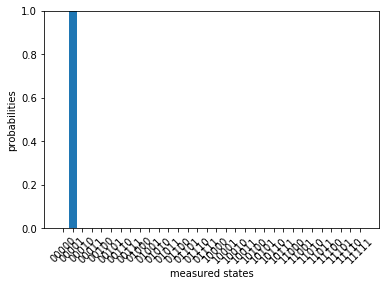

In [10]:
qc = adder(a="0010", b="0001")

# run ciruit no noise
print("simulating quantum computer")
backend = backends["Aer.qasm_simulator"]
job = execute(qc, backend=backend, shots=1000)
#job = execute(qc, backend=backend, coupling_map=couple, noise_model=noise_model, basis_gates=basis_gates, shots=10000)

counts = job.result().get_counts()

# show results
print(f"\nquantum computer simulator results:\n{counts}")
plt.show(plot_histogram(counts))